# The GCM model

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np

import bayesflow as bf
import json

The basic model has three parameters - generalization (c), attention
weight (w), and bias (b). In this example, we assume no bias between the
categories, so b will be fixed to $\frac{1}{2}$.

### Data

We use the category learning data from the “Condensation B” condition
reported by Kruschke (1993).

In [2]:
with open(os.path.join("data", "KruschkeData.json")) as f:
    data = json.load(f)

data.keys()

dict_keys(['a', 'd1', 'd2', 'n', 'nstim', 'nsubj', 'y'])

The element `y` contains the array of responses $y_{ik}$ for the trial
$i \in \{1, \dots, 8\}$ and participant $k \in \{1, \dots, 40\}$.

In [3]:
np.array(data['y']).shape

(8, 40)

`d1` and `d2` contain the physical distances between the 8 stimuli on
the along the two dimensions, such that

The indicator vector `a` contains information whether the stimulus $a_i$
is an element from Category A or an element from Category B.

Here we will assume that the design of the experiment (i.e., number of
trials, number of stimuli, number of participants, nature of the
stimuli) is fixed. That is, we will only amortize over the observation
outcomes.

### Simulator

In [4]:
def prior():
    return dict(
        c = np.random.exponential(scale=1),
        w = np.random.uniform(low=0, high=1)
    )

def likelihood(c, w, n=data['n'], nstim=data['nstim'], nsubj=data['nsubj'], d1=np.array(data['d1']), d2=np.array(data['d2']), a=np.array(data['a'])):
    b = 0.5

    s = np.exp( - c * (w * d1 + (1-w) * d2))

    r = np.zeros((nsubj, nstim))

    for i in range(nstim):
        isA = a == 1
        isB = a != 1

        numerator = b * np.sum(s[i,isA])
        denominator = numerator + (1-b) * np.sum(s[i,isB])

        r[:, i] = numerator / denominator

    y = np.random.binomial(n=n, p=r, size=(nsubj, nstim))

    return dict(y=y)

simulator = bf.make_simulator([prior, likelihood])

### Approximator

In [5]:
adapter = (bf.Adapter()
    .constrain("c", lower=0)
    .constrain("w", lower=0, upper=1)
    .concatenate(["c", "w"], into="inference_variables")
    .rename("y", "summary_variables")
)

In [ ]:
workflow=bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow(),
    summary_network=bf.networks.DeepSet(),
    initial_learning_rate=1e-3
)

### Training

In [ ]:
history=workflow.fit_online(batch_size=256)

### Validation

In [8]:
test_data = simulator.sample(1000)

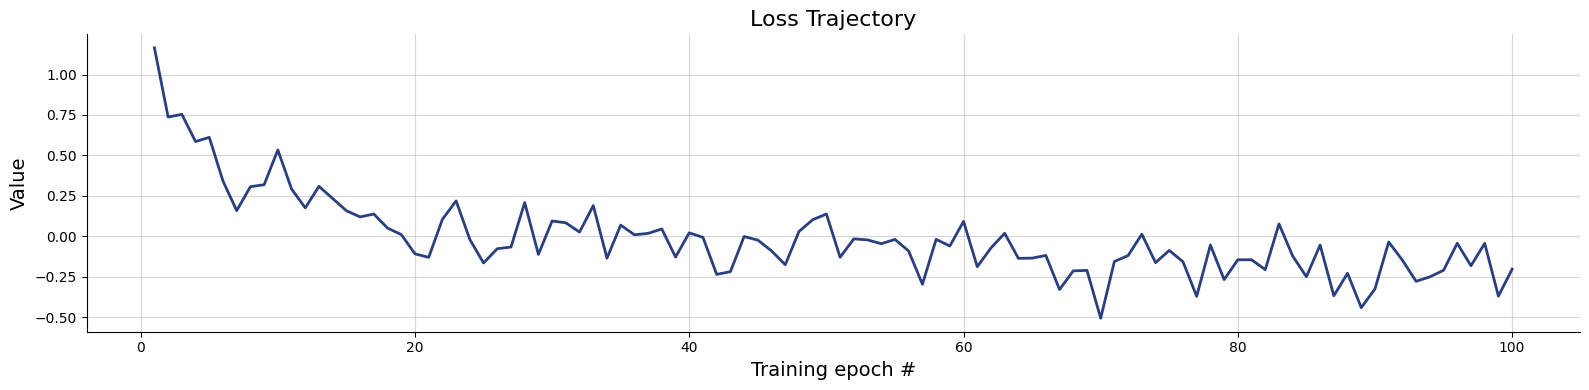

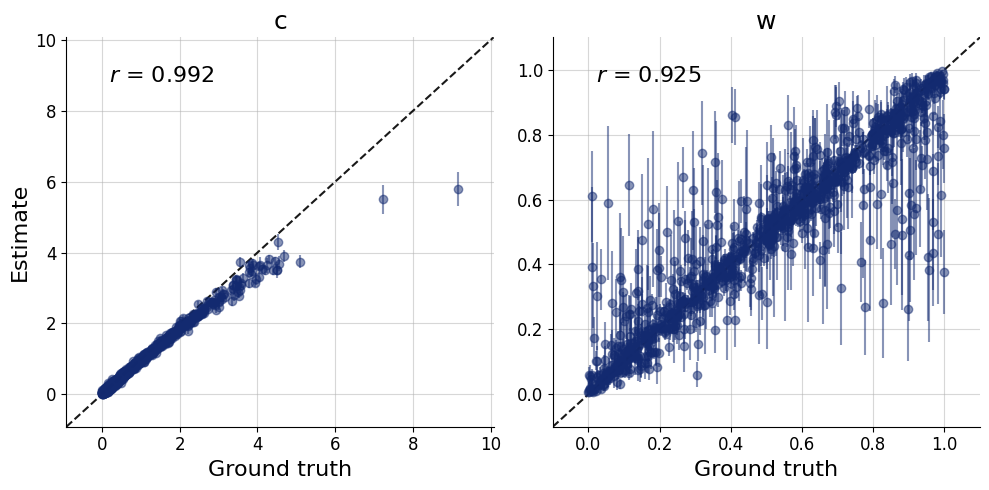

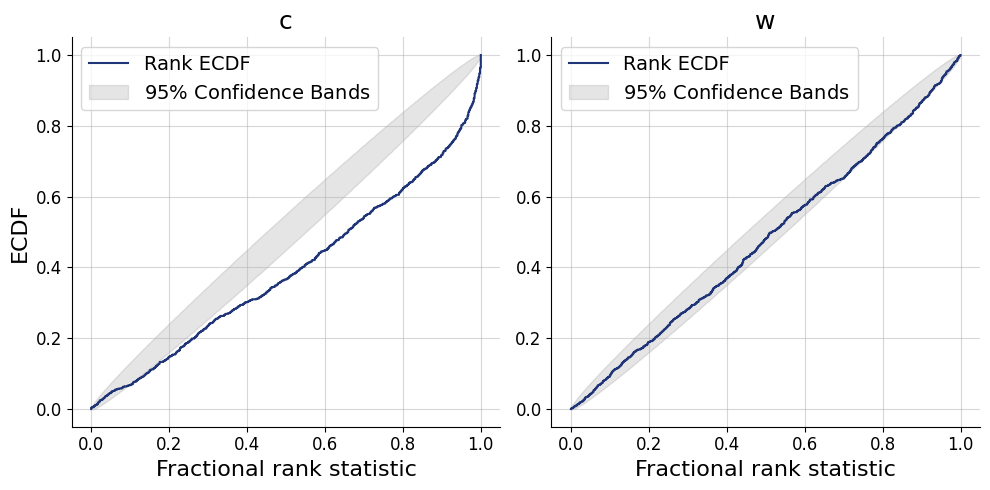

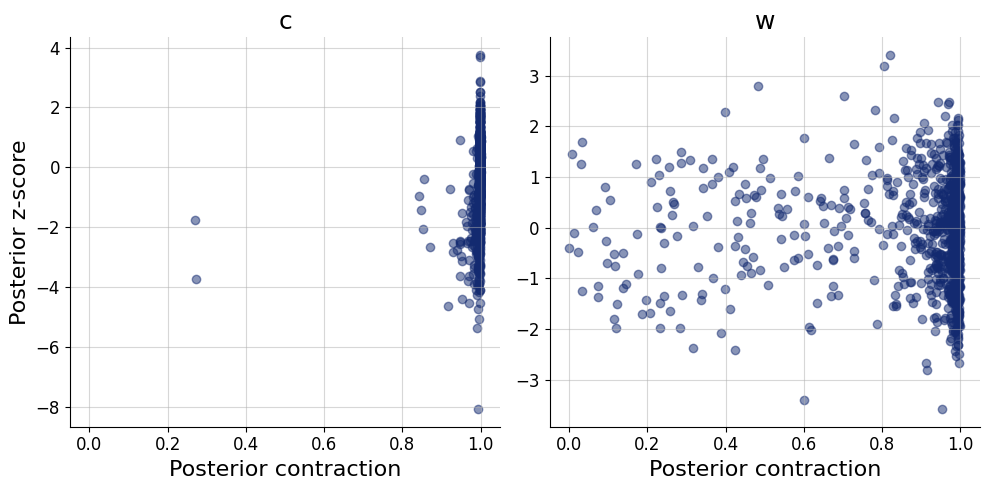

In [9]:
figs = workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

Here we apply the networks to the data from Kruschke (1993) as reported
by Lee & Wagenmakers (2013). The quantity of interest is the joint
posterior distribution of parameters $c$ and $w$.

In [10]:
inference_data = dict(y = np.array(data['y']).transpose()[np.newaxis,...])

In [11]:
posterior_samples = workflow.sample(num_samples=2000, conditions=inference_data)

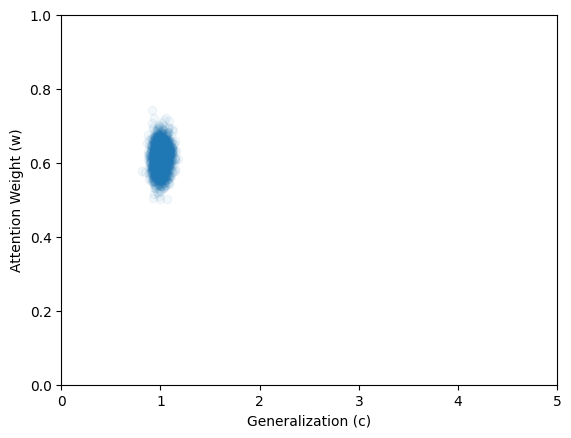

In [12]:
plt.scatter(
    x = posterior_samples['c'],
    y = posterior_samples['w'],
    alpha=0.05
)
plt.xlim([0, 5])
plt.ylim([0, 1])
plt.xlabel("Generalization (c)")
f=plt.ylabel("Attention Weight (w)")

Kruschke, J. K. (1993). Human category learning: Implications for
backpropagation models. *Connection Science*, *5*(1), 3–36.

Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.